# RTS Smoothing
This notebook explores the Rauch-Tung-Striebel Smoother on a problem described in "Bayesian Filtering and Smoothing" by Sarkka.

We start by implementing a class that produces data -- see Example 4.3 in the book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let us start by implementing a simple state space model.

In [2]:
class StateSpace:    
    def __init__(self, A, H, Q, R):
        self.A = A # state-transition matrix 
        self.H = H # observation matrix
        self.Q = Q # state noise covariance
        self.R = R # observation noise covariance
        self.reset_state() # sets state
    def reset_state(self):
        self.x = np.zeros(self.A.shape[0])
    def __call__(self):
        """
        single data generation step,
        outputs the observations and the current state
        """
        self.x = self.A.dot(self.x) + np.random.multivariate_normal(np.zeros(self.x.size), self.Q)
        obs = self.H.dot(self.x) + np.random.multivariate_normal(np.zeros(self.H.shape[0]), self.R)
        return obs, self.x.copy()

In order to specialize this class to our specific example, we define a function to create the matrices we need. We will also use this function to initialize the Kalman filter in the sequel.

In [3]:
def create_matrices(dt = 1e-1, q1=1., q2=1., sigma1=0.5, sigma2=0.5):
    """
    creates the matrices A, H, Q, R,
    used in Ex 4.3 in Sarkka's book
    """
    iden = np.eye(2)
    z = np.zeros((2,2))
    A = np.block([[iden,dt * iden],
                  [z, iden]
                 ])
    H = np.block([iden, z])
    q = np.array([q1,q2])
    b1 = np.diag(dt**3/3 * q)
    b2 = np.diag(dt**2/2 * q)
    b3 = np.diag(dt * q)
    Q = np.block([[b1,b2],[b2,b3]])
    R = np.diag([sigma1**2, sigma2**2])
    return A, H, Q, R

We are ready to produce some data.

In [4]:
matrices = create_matrices()
car = StateSpace(*matrices)
# car.x[2:] = np.random.normal(0,0.1,2) # initialize with non-zero velocity
dat = [car() for _ in range(100)]
obs, states = [np.stack(x) for x in zip(*dat)]

In [5]:
def plot_obs(ax, obs, markersize = 3):
    ax.plot(obs[:,0], obs[:,1], ".-", markersize=markersize, linewidth=0.5)
    ax.plot(obs[0,0], obs[0,1], ".", markersize = 2*markersize, c = "r", label = "origin")
    ax.plot(obs[-1,0], obs[-1,1], ".", c = "y", markersize = 2*markersize,label = "last point")
    ax.axis("equal")
    return ax

Text(0.5, 1.0, 'observed data')

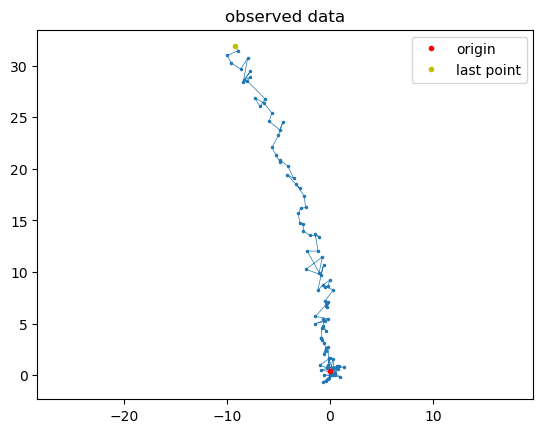

In [6]:
fig, ax = plt.subplots()
ax = plot_obs(ax, obs)
ax.legend()
ax.set_title("observed data")

Let us now implement a Kalman filter.

In [7]:
class KalmanFilter:
    def __init__(self, A, H, Q, R, initial_variance = 0.1):
        self.A = A
        self.H = H
        self.Q = Q
        self.R = R
        self.initial_variance = initial_variance
        self.reset()
        
    def reset(self):
        self.x = np.zeros(self.A.shape[0])
        self.P = self.initial_variance * np.eye(self.x.size)
        
    def propagate(self):
        self.x = self.A.dot(self.x)
        self.P = self.A.dot(self.P.dot(self.A.transpose())) + self.Q
        
    def __call__(self, obs):
        """
        given observations,
        return the estimate
        """
        self.propagate()
        rhs = obs - self.H.dot(self.x)
        HP = self.H.dot(self.P)
        gain_t = np.linalg.solve(self.H.dot(self.P.dot(self.H.transpose())) + self.R, HP)
        self.x += gain_t.transpose().dot(rhs)
        self.P = self.P - HP.transpose().dot(gain_t)
        return self.x.copy()

In [8]:
kf = KalmanFilter(*matrices)

In [9]:
estimates = {}
estimates["KF"] = np.stack([kf(x)[:2] for x in obs])

Text(0.5, 1.0, 'Kalman Filter Estimate')

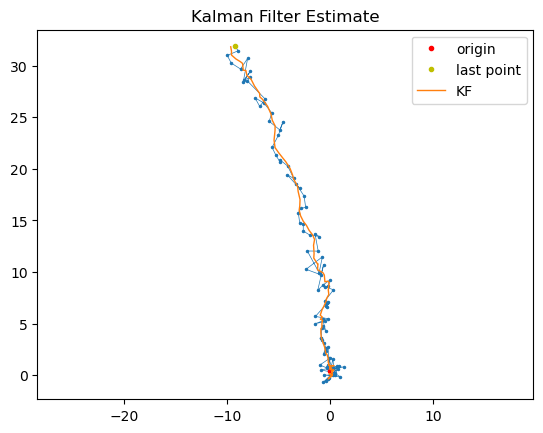

In [10]:
fig, ax = plt.subplots()
plot_obs(ax,obs)
for label, est in estimates.items():
    ax.plot(est[:,0], est[:,1], "-", linewidth=1, label = label)
ax.axis("equal")
ax.legend()
ax.set_title("Kalman Filter Estimate")

We are ready to implement the RTS smoother. Note that this smoother employs an object of class `KalmanFilter`. When calling this smoother, we need to provide the whole set of observations.

In [11]:
class Smoother:
    """
    RTS Smoother
    """
    def __init__(self, A, H, Q, R):
        self.A = A
        self.H = H
        self.Q = Q
        self.R = R
        self.kf = KalmanFilter(A, H, Q, R)
    
    def backward_step(self, m_0, P_0, m_1_s, P_1_s):
        """
        m_0 - m_k
        P_0 - P_k
        m_1_s - m_{k+1}^s
        P_1_s - P_{k+1}^s
        """
        m_minus = self.A.dot(m_0)
        P_minus = self.A.dot(P_0.dot(self.A.transpose())) + self.Q
        G_t = np.linalg.solve(P_minus, self.A.dot(P_0))
        m_0_s = m_0 + G_t.transpose().dot(m_1_s - m_minus)
        P_0_s = P_0 + G_t.transpose().dot((P_1_s - P_minus).dot(G_t))
        return m_0_s, P_0_s
    
    def __call__(self, obs):
        
        """
        returns the list of
        state estimates and variance
        """
        # collect KF estimates in a forward pass
        x_fwd = []
        P_fwd = []
        for x in obs:
            x_fwd.append(self.kf(x))
            P_fwd.append(self.kf.P.copy())
        x_fwd = x_fwd[::-1]
        P_fwd = P_fwd[::-1]
        smooth_m = [x_fwd[0]]
        smooth_P = [P_fwd[0]]
        for m_0, P_0 in zip(x_fwd[1:], P_fwd[1:]):
            m, P = self.backward_step(m_0, P_0, smooth_m[-1], smooth_P[-1])
            smooth_m.append(m.copy())
            smooth_P.append(P.copy())
        return np.stack(smooth_m[::-1]), np.stack(smooth_P[::-1])

We initialize the smoother the same way we did with `KalmanFilter`.

In [12]:
sm = Smoother(*matrices)

We get the list of updated means and covariances -- note that we input the whole set of observations.

In [13]:
smoother_mean, smoother_cov = sm(obs)
estimates["RTS"] = smoother_mean

Here are the resulting estimates.

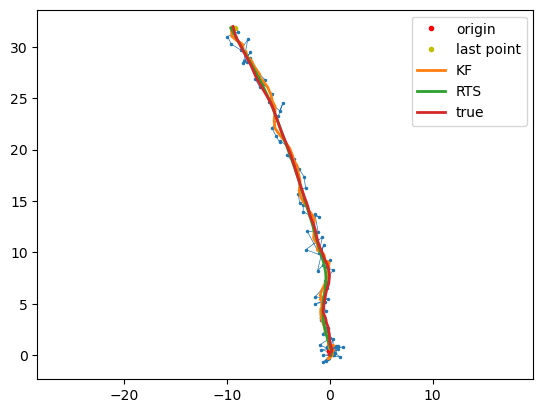

In [14]:
estimates["true"] = states
fig, ax = plt.subplots()
plot_obs(ax,obs)
for label, est in estimates.items():
    ax.plot(est[:,0], est[:,1], linewidth=2, label = label)
ax.plot
ax.axis("equal")
ax.legend()

**Ilker bayram, ibayram@ieee.org, 2023**